<a href="https://colab.research.google.com/github/Nadia-Moulouad/Forecasting-Scochastic-Model/blob/main/non_seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non seasonal data analysis

The data was found on kaggle : https://www.kaggle.com/datasets/sahirmaharajj/school-student-daily-attendance
It represents the daily listing (counts) of students registered, present and absent in multiple schools (each school is represented by 'School DBN').

Each record includes the date, total enrollment, number of students absent and present on that day.
the date format has been modified by me in excel for mor clarity.

In [1]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for plots
from statsmodels.tsa.seasonal import seasonal_decompose, STL # to check for seasonality, not sure if useful in this situation.
from statsmodels.tsa.stattools import adfuller # augmented Dickey-Fuller test

# ploting the time series versus time

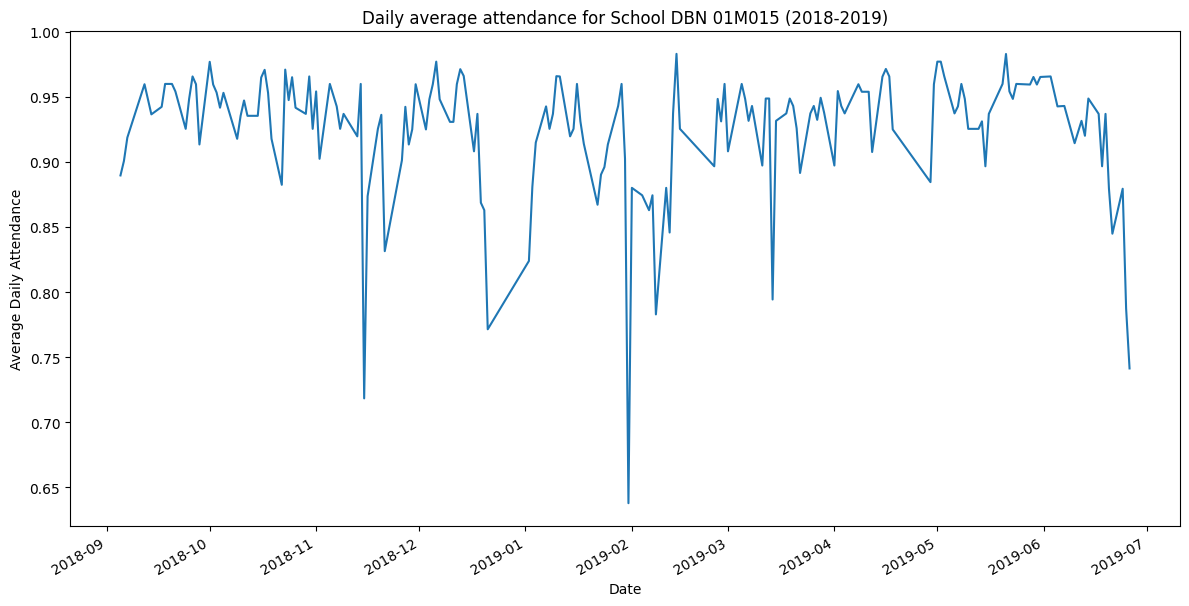

In [5]:
# Reading csv file & putting it in a dataframe
df = pd.read_csv('2018-2019_Daily_Attendance_one_school.csv')

# only choosing rows where school dnb is 01M015 (dayly attendence in school n°01M015)
df = df[df['School DBN'] == '01M015']

# date column to datetime
df['Date'] = pd.to_datetime(df['Date(well formated)'], format='%d/%m/%Y')

# finding daily average attendance
df['Average_Attendance'] = df['Present'] / df['Enrolled']

# creating fig and axis
fig, ax = plt.subplots(figsize=(12, 6))

# plotting data
ax.plot(df['Date'], df['Average_Attendance'])
ax.set_xlabel('Date')
ax.set_ylabel('Average Daily Attendance')
fig.autofmt_xdate()
plt.tight_layout()
plt.title('Daily average attendance for School DBN 01M015 (2018-2019)')

# save plot
plt.savefig('figures/average_daily_attendance_01M015.png', dpi=300)


# checking for seasonality (using STL)

There doesn't seem to be a clear sesonal component in this time series.

In [6]:
# period is the number of observations in the cycle
advanced_decomposition = STL(df.Average_Attendance, period=178).fit()

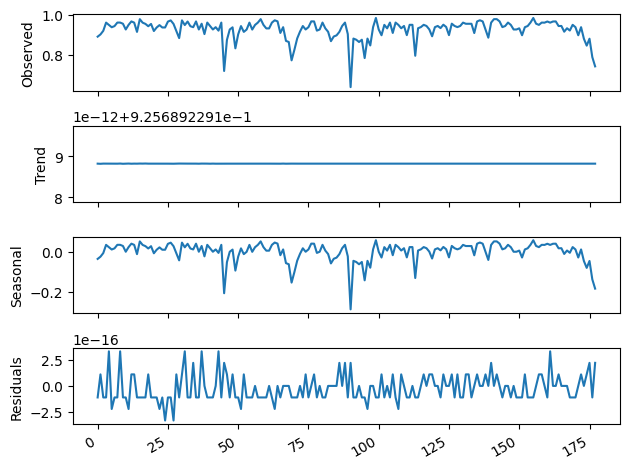

In [7]:
# decomposing the time series into Trend, Seasonality and residual
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/STL.png', dpi=300)



# Dickey-Fuller(ADF) test to see if the data is stationary or not

The ADF statistic is a large negative number (-5.56), and the p-value is much smaller than 0.05,which means we can reject the null
hypothesis stating that our time series is not stationary.
Therefore, the data for this time series can be considered stationary with a pretty high degree of confidence.

In [8]:
# Perform the ADF test on the 'Average_Attendance' column of the 'df' dataframe
ADF_result = adfuller(df['Average_Attendance'])

# Print the ADF statistic obtained from the ADF test
print(f'ADF Statistic: {ADF_result[0]}')

#Print the p-value obtained from the ADF test
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.5639493254930015
p-value: 1.5196201186840443e-06


# Plotting the auto corellation function (ACF) to get an idea of which model to apply

We notice that the coefficients are significant up until lag 2 or 3, and then they fall into the non-significance zone on the plot.

the fact that there are signs of auto corellation after lag 0 means that this is not a random walk, there seems to be more of a slow decay rather than an abruptfall (which excludesMA(q) process) into the nonsignificance zone after lag 3 means that there is a statistically significant autocorrelation untill that lag. This shows that the time series has a short-term dependency structure.

when we plot the pacf, we see that
there is an abrupt fall after lag 1. This seems to indicate an AR(p) process.

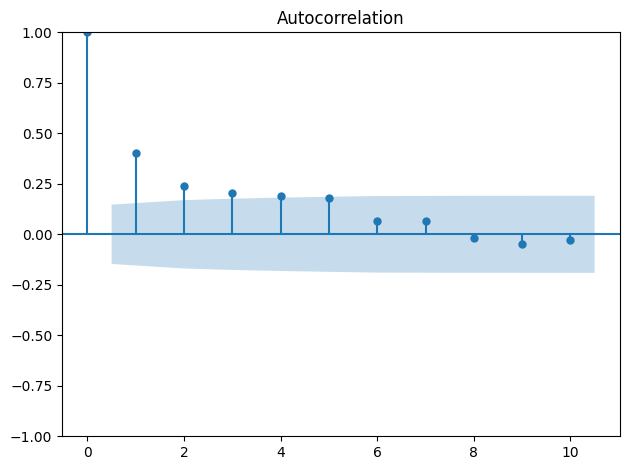

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['Average_Attendance'], lags=10)
plt.tight_layout()
plt.savefig('figures/acf.png', dpi=300)

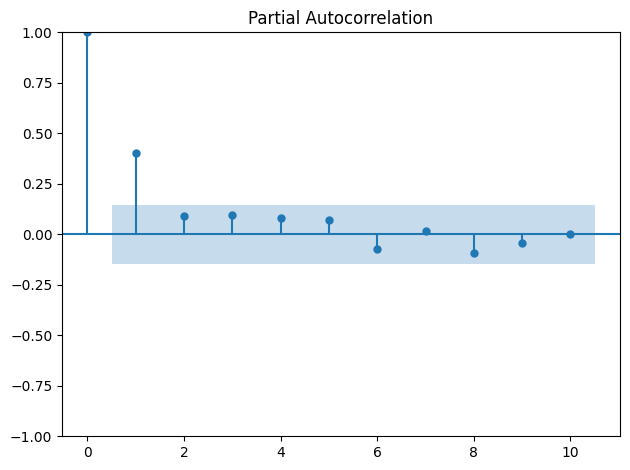

In [10]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Average_Attendance'], lags=10)

plt.tight_layout()

plt.savefig('figures/pacf.png', dpi=300)

# Forecasting using the AR(p) model
In our case, we discovered that the Student attendence seems to be a  autoregressive process of order 1, or an AR(1) process.

In [11]:
# Split data into training and testing
df_av_attendance = pd.DataFrame({'Average_Attendance': df['Average_Attendance']})

train = df_av_attendance[:int(0.80*len(df_av_attendance))]
test = df_av_attendance[int(0.80*len(df_av_attendance)):]

print(len(train))
print(len(test))

142
36


Using the rolling forecast function from the course.

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'AR':
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [13]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_av_attendance, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_av_attendance, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR = rolling_forecast(df_av_attendance, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

test.head()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-13-eca5b96ac45f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
<ipython-input-13-eca5b96ac45f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,Average_Attendance,pred_mean,pred_last_value,pred_AR
142,0.976879,0.925098,0.976879,0.975803
143,0.965714,0.925461,0.976879,0.975811
144,0.937143,0.925740,0.965714,0.964582
145,0.942529,0.925819,0.937143,0.935843
146,0.959770,0.925933,0.942529,0.941269


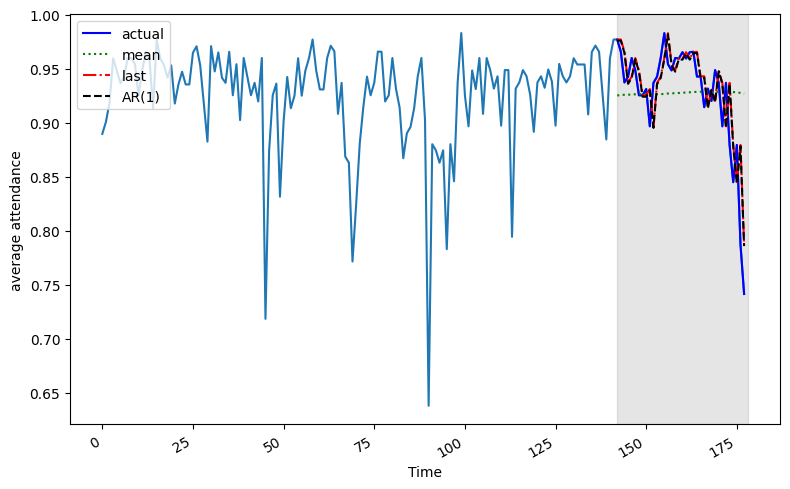

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(df_av_attendance['Average_Attendance'])
ax.plot(test['Average_Attendance'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(1)')

ax.legend(loc='upper left')  # Adjusted legend position for better visibility
# Set axis labels
ax.set_xlabel('Time')
ax.set_ylabel('average attendance')
# Highlight the test data region with a shaded area
ax.axvspan(142, 178, color='#808080', alpha=0.2, label='Test Data Region')
# Format x-axis for readability (optional)
fig.autofmt_xdate()

# Ensure layout is tight to avoid overlapping elements
plt.tight_layout()
plt.savefig('figures/AR_process.png', dpi=300)
plt.show()
